In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
data_dir = 'datasets'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

100

In [3]:
raw_durian_images_dict = {
    'ripe' : list(data_dir.glob('ripe/*')),
    'unripe' : list(data_dir.glob('unripe/*')),
} 
raw_durian_labels_dict = {
    'ripe' : 0,
    'unripe' : 1
}

In [4]:
X, y = [], []

output_folder = "resized_images"

for durian_ripeness, images in raw_durian_images_dict.items():
    for index, image in enumerate(images):
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(200,200))
        X.append(resized_img)
        y.append(raw_durian_labels_dict[durian_ripeness])
        
        # Uncomment if you want to check all the resized images
        output_name = f"{durian_ripeness}_{index}.jpg"
        output_path = os.path.join(output_folder, output_name)
        cv2.imwrite(output_path, resized_img)

In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train_scaled = X_train /255
X_test_scaled = X_test /255

In [7]:
convDim = 3
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (convDim,convDim), activation='relu', input_shape=(200,200,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.25),  # Add dropout layer
    tf.keras.layers.Conv2D(32, (convDim,convDim), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.25),  # Add dropout layer
    tf.keras.layers.Conv2D(64, (convDim,convDim), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),  # Add dropout layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.25),  # Add dropout layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),  # Add dropout layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),  # Add dropout layer
    tf.keras.layers.Dense(8, activation='relu'),    
    tf.keras.layers.Dropout(0.25),  # Add dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

c:\Users\induction motor\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when the loss falls below 0.4

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the loss
    if(logs.get('accuracy') == 1.0):

      # Stop if threshold is met
      print("\Accuracy is reached than 1.0 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [9]:
EPOCH = 50
BATCH_SIZE = 32
model_fit = model.fit(X_train_scaled, y_train, epochs=EPOCH, validation_data=(X_test_scaled, y_test), batch_size=BATCH_SIZE, 
                    #   callbacks=callbacks
                      ) 

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step - accuracy: 0.4955 - loss: 0.7271 - val_accuracy: 0.5200 - val_loss: 0.7083
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.4822 - loss: 0.8615 - val_accuracy: 0.5200 - val_loss: 0.6902
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 0.5201 - loss: 0.7232 - val_accuracy: 0.6800 - val_loss: 0.6854
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.4955 - loss: 0.6833 - val_accuracy: 0.7600 - val_loss: 0.6881
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - accuracy: 0.5284 - loss: 0.6855 - val_accuracy: 0.7600 - val_loss: 0.6888
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.6286 - loss: 0.6671 - val_accuracy: 0.8000 - val_loss: 0.6826
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.5339 - loss: 0.6761 - val_accuracy: 0.5600 - val_loss: 0.6697
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - accuracy: 0.5511 - loss: 0.6417 - val_accuracy: 0.6000 - val_loss:

In [10]:
model.evaluate(X_test_scaled,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1344e-04


[0.00011343544611008838, 1.0]

In [11]:
predictions = model.predict(X_test_scaled)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


array([[1.5259629e-06],
       [9.9998575e-01],
       [8.0405887e-05],
       [9.9990708e-01],
       [9.9978119e-01],
       [9.9997532e-01],
       [4.7865142e-06],
       [9.9999464e-01],
       [9.9999350e-01],
       [9.9999756e-01],
       [9.9997646e-01],
       [9.9997205e-01],
       [9.9999660e-01],
       [1.4407234e-04],
       [7.9267158e-04],
       [5.1240590e-06],
       [3.8324968e-05],
       [2.9690534e-06],
       [5.0900539e-06],
       [4.4876615e-05],
       [7.8596182e-05],
       [9.9946654e-01],
       [3.2842957e-04],
       [1.0000000e+00],
       [3.5502177e-04]], dtype=float32)

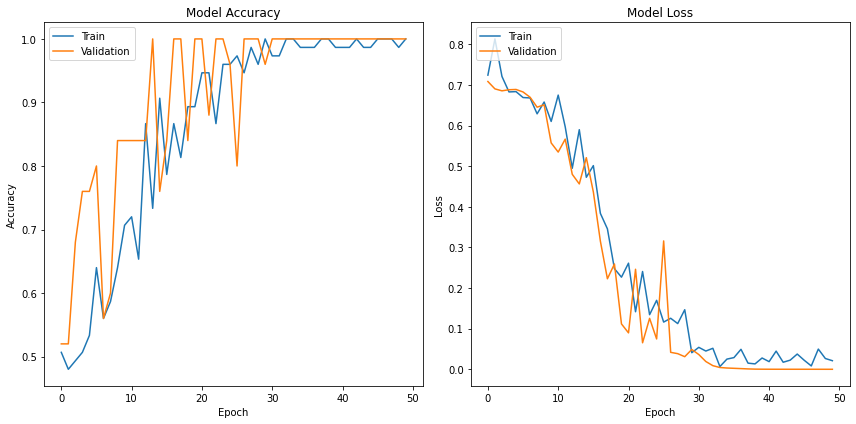

In [12]:
# Plot training and validation history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])  # Add validation accuracy
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])  # Add validation loss
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


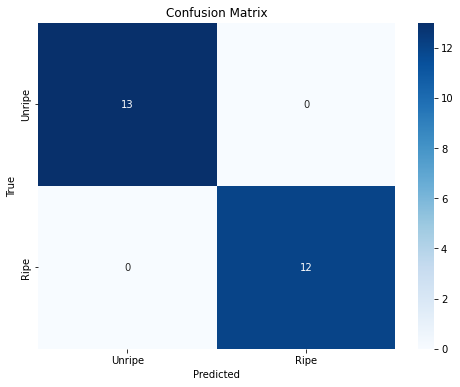

In [13]:
# Generate predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Assuming it's a binary classification problem

# Generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Unripe', 'Ripe'], yticklabels=['Unripe', 'Ripe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()